In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l

In [ ]:
pip uninstall matplotlib

In [ ]:
pip install --upgrade pip

In [ ]:
pip install matplotlib

## 注意力提示

In [7]:
# 注意力的可视化
import torch
from d2l import torch as d2l

In [8]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5), cmap='Reds'):
  '''显示矩阵热图'''
  d2l.use_svg_display()
  num_rows, num_cols = matrices.shape[0], matrices.shape[1]
  fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize, sharex=True, sharey=True, squeeze=False)
  for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
    for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
      pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
      if i == num_rows - 1:
        ax.set_xlabel(xlabel)
      if j == 0:
        ax.set_ylabel(ylabel)
      if titles:
        ax.set_title(titles[j])
  fig.colorbar(pcm, ax=axes, shrink=0.6)

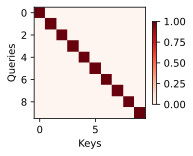

In [9]:
attention_weights = torch.eye(10).reshape(1, 1, 10, 10)
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

## 注意力汇聚：Nadaraya-Watson核回归

In [10]:
import torch
from torch import nn
from d2l import torch as d2l

In [11]:
# 生成数据集
n_train = 50 # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5) # 排序后的训练样本
def f(x):
  return 2 * torch.sin(x) + x ** 0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train, )) # 训练样本的输出
x_test = torch.arange(0, 5, 0.1) # 测试样本
y_truth = f(x_test) # 测试样本的真实输出
n_test = len(x_test)
n_test

50

In [12]:
def plot_kernel_reg(y_hat):
  d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'], xlim=[0, 5], ylim=[-1, 5])
  d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

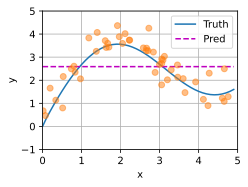

In [13]:
# 平均汇聚
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

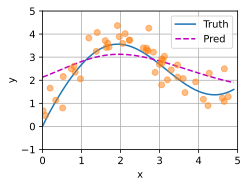

In [16]:
# 非参数注意力汇聚
# X_repeat的形状为(n_test, n_train)
# 每一行都包含相同的测试输入（例如同样的查询）
X_repeat = x_test.repeat_interleave(n_train).reshape(-1, n_train)
# x_train包含键。attention_weights的形状为(n_test, n_train)
# 每一行都包含要在给定的每个查询的值（y_train）之间分配的注意力权重
attention_weights = nn.functional.softmax(-(X_repeat - x_train) ** 2 / 2, dim=1)
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

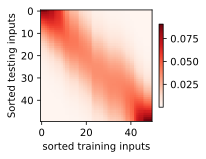

In [17]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='sorted training inputs',
                  ylabel='Sorted testing inputs')

In [19]:
# 带参数的注意力汇聚
# 批量矩阵乘法
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

In [20]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

In [24]:
# 定义模型
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        # values的形状为(查询个数，“键－值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

In [25]:
# 训练
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

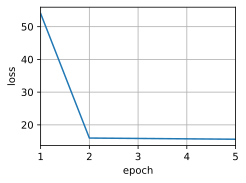

In [28]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

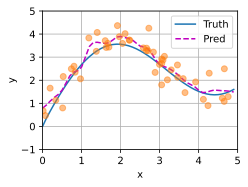

In [30]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

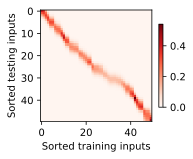

In [33]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')